In [1]:
import os

import numpy as np

# from jax import numpy as jnp
# from jax import random
# from flax import linen as nn

# from evojax.task.brax_task import BraxTask

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mediapy as media

%matplotlib inline

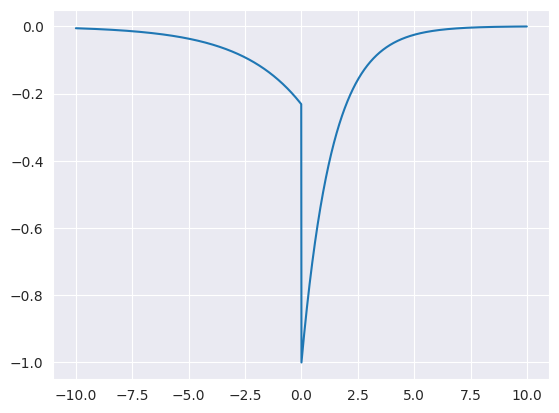

In [2]:
def test(lr, a, b, c, d, w=0):
    x = np.arange(-10, 10, 1e-2)   # pre - post
    x_neg = np.exp(x[:x.shape[0] // 2] / np.e)    # pre - post <= 0
    x_pos = np.exp(-x[x.shape[0] // 2:] / np.e)

    dw_neg = lr * (a * x_neg / np.e ** 2 + b * x_neg / np.e + c * x_neg + d)
    dw_pos = lr * (b * w * x_pos * x_pos + d)
    dw = np.concatenate([dw_neg, dw_pos])

    plt.plot(x, dw)
    plt.show()

test(1., 1., -1., 0., 0., 1.)

In [2]:
def plot_dt_dw(lr, a, b, c, d, e=0., f=0., g=0., h=0., tau_pre=1./np.e, tau_post=1./np.e, w=0.):
    x = np.arange(-10, 10, 1e-2)
    x_neg = x[:x.shape[0] // 2]
    x_pos = x[x.shape[0] // 2:]

    dw_neg = lr * (b * np.exp(tau_pre * x_neg) + d + (f * np.exp(tau_pre * x_neg) + h) * w)
    dw_pos = lr * ((a + c) * np.exp(-tau_post * x_pos) + d + ((e + g) * np.exp(-tau_post * x_pos) + h) * w)
    dw = np.concatenate([dw_neg, dw_pos])
    plt.plot(x, dw)
    # plt.fill_betweenx(dw_neg, x_neg, color='r')
    # plt.fill_betweenx(dw_pos, x_pos, color='b')
    plt.show()

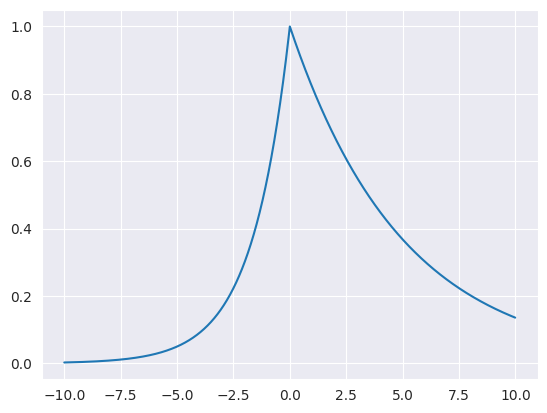

In [3]:
plot_dt_dw(1., 0., 1., 1., 0., 0., .0, .0, 0, w=0., tau_pre=.6, tau_post=.2)

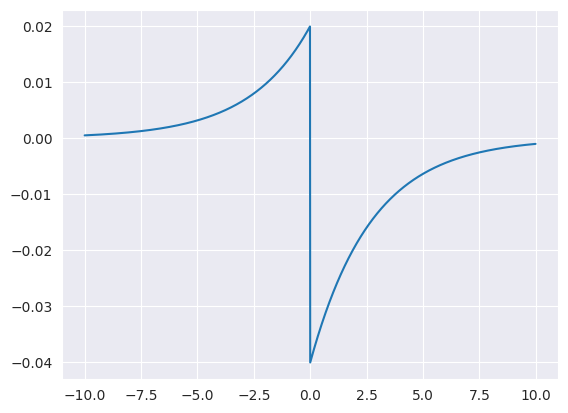

In [8]:
plot_dt_dw(0.1, 0., .2, -.4, 0)

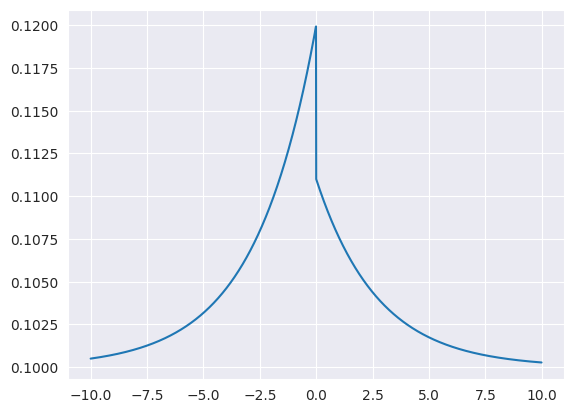

In [5]:
plot_dt_dw(0.1, .01, .2, .1, 1)

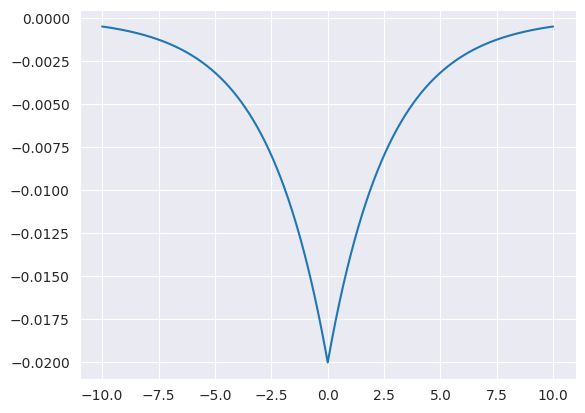

In [6]:
plot_dt_dw(0.1, -.1, -.2, -.1, 0)

In [70]:
def plot_dt_dw_3d(lr, a, b, c, d, e=0., f=0., g=0., h=0., tau_pre=1./np.e, tau_post=1./np.e):
    _x = np.arange(-5, 5, 1e-2)
    _y = np.arange(-5, 5, 1e-2)
    x, y = np.meshgrid(_x, _y)
    x_neg = x[:, :x.shape[1] // 2]
    x_pos = x[:, x.shape[1] // 2:]
    y_neg = y[:, :x.shape[1] // 2]
    y_pos = y[:, x.shape[1] // 2:]
    print(x.shape, y.shape)

    dw_neg = lr * (b * np.exp(tau_pre * x_neg) + d + (f * np.exp(tau_pre * x_neg) + h) * y_neg)
    dw_pos = lr * ((a + c) * np.exp(-tau_post * x_pos) + d + ((e + g) * np.exp(-tau_post * x_pos) + h) * y_pos)
    dw = np.concatenate([dw_neg, dw_pos], axis=1)

    # x = np.arange(-10, 10, 1e-2)
    # y = np.arange(-10, 10, 1e-2)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot(x, y)
    scale = np.max(np.abs(dw))
    ax.plot_surface(x, y, dw, cmap=plt.cm.coolwarm, vmin=-scale, vmax=scale)
    # plt.fill_betweenx(dw_neg, x_neg, color='r')
    # plt.fill_betweenx(dw_pos, x_pos, color='b')
    plt.show()

    sns.heatmap(dw, center=0, xticklabels=False, yticklabels=False)
    plt.show()

(1000, 1000) (1000, 1000)


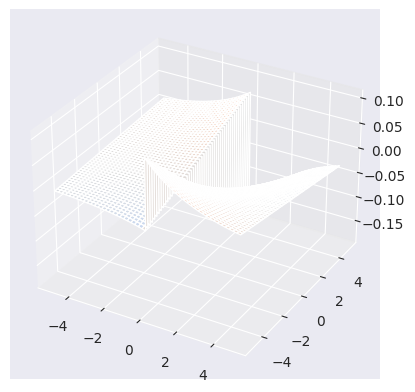

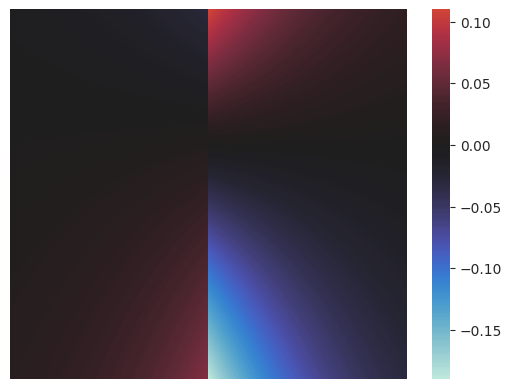

In [71]:
plot_dt_dw_3d(0.1, 0., .2, -.4, 0, 0., .1, -.3, 0)

In [2]:
def sim(pre, post, lr, a, b, c, d, e=0., f=0., g=0., h=0., w=0., tau_pre=1./np.e, tau_post=1./np.e):
    length = pre.shape[0]
    pre_traces, post_traces, ws = [0.], [0.], [w]
    for t in range(length):
        x = pre[t] * tau_pre + pre_traces[t] * (1. - tau_pre)
        y = post[t] * tau_post + post_traces[t] * (1. - tau_post)
        pre_traces.append(x)
        post_traces.append(y)

        dw = lr * (a * x * y + b * x + c * y + d + (e * x * y + f * x + g * y + h) * ws[t])
        ws.append(ws[t] + dw)

    return pre_traces, post_traces, ws

def sim_plot(pre, post, pre_traces, post_traces, ws):
    fig, axes = plt.subplots(5, 1, sharex=True)

    idx_pre, idx_post = np.where(pre == 1)[0], np.where(post == 1)[0]
    print(idx_pre)
    axes[0].vlines(list(idx_pre), 0, 1)
    axes[1].vlines(list(idx_post), 0, 1)

    axes[2].plot(pre_traces)
    axes[3].plot(post_traces)

    axes[4].plot(ws)

    plt.show()

In [3]:
pre, post = np.zeros(100), np.zeros(100)
pre[np.random.choice(100, (5,), replace=False)] = 1
post[np.random.choice(100, (5,), replace=False)] = 1

pre_traces, post_traces, ws = sim(pre, post, 0.1, 0., .2, -.4, 0, 0., .1, -.3, 0)

[ 8 23 50 83 97]


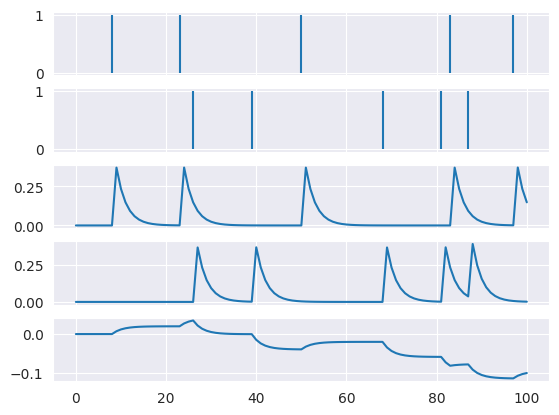

In [4]:
sim_plot(pre, post, pre_traces, post_traces, ws)

In [7]:
import jax
import evojax
from evojax.task.brax_task import BraxTask
from evojax.task.gym_task import Gym
from evojax.algo import PGPE, OpenES
from evojax import ObsNormalizer
from evojax import SimManager
from evojax.policy.base import PolicyState
from brax import envs
from brax.io import html

In [54]:
class Empty:
    pass
args = Empty()
args.algo = 'PGPE'
args.env = 'ur5e'
args.policy = 'MetaWeightedStdpMLPPolicy'
args.ckpt_dir = '/data/floyed/meta/train/PGPE-MetaWeightedStdpMLPPolicy-ur5e--20230311-204358'
args.hidden_dims = [128, 64]

args.center_lr = 0.01
args.init_std = 0.04
args.decay_std = 0.999
args.limit_std = 0.001
args.std_lr = 0.07
args.seed = 42

In [55]:
# /data/floyed/meta/train/PGPE-MetaWeightedStdpMLPPolicy-ur5e--20230310-114057
# /data/floyed/meta/train/PGPE-MetaWeightedStdpMLPPolicy-ant_dir--20230310-114106
# /data/floyed/meta/train/PGPE-MetaWeightedStdpMLPPolicy-swimmer_dir--20230310-114117
# /data/floyed/meta/train/PGPE-MetaWeightedStdpMLPPolicy-halfcheetah_vel--20230310-114128
# /data/floyed/meta/train/PGPE-MetaWeightedStdpMLPPolicy-swimmer_dir--20230311-204359
# /data/floyed/meta/train/PGPE-MetaWeightedStdpMLPPolicy-halfcheetah_vel--20230311-204359
# /data/floyed/meta/train/PGPE-MetaWeightedStdpMLPPolicy-ur5e--20230311-204358
from typing import Tuple

def _clip(tau):
    return np.clip(0.1 * tau + 1. / jnp.e, 0.2, .8)


def load_model(model_dir: str) -> Tuple[np.ndarray, np.ndarray, int, float, int]:
    model_file = os.path.join(model_dir, 'best.npz')
    if not os.path.exists(model_file):
        raise ValueError('Model file {} does not exist.')
    with np.load(model_file, allow_pickle=True) as data:
        params = data['params']
        obs_params = data['obs_params']
        epoch = data.get('epoch', 0)
        score = data.get('score', -float('Inf'))
        steps = data.get('steps', 0)
    return params, obs_params, epoch, score, steps

In [56]:
best_params, obs_params, epoch, score, steps = load_model(args.ckpt_dir)

In [57]:
train_task = BraxTask(
        env_name=args.env,
        test=False,
        num_tasks=8
        # terminate_when_unhealthy=args.terminate_when_unhealthy
    )
test_task = BraxTask(
    env_name=args.env,
    test=True,
    num_tasks=8
    # terminate_when_unhealthy=args.terminate_when_unhealthy
)
# train_task = Gym('HumanoidStandup-v4', pop_size=args.pop_size, test=False)
# test_task = Gym('HumanoidStandup-v4', pop_size=args.pop_size, test=True)

# Create  Policy
# policy = getattr(evojax.policy, args.policy)(
#     hidden_dims=[
#         train_task.obs_shape[0],
#         *args.hidden_dims,
#         train_task.act_shape[0]
#     ]
# )
policy = getattr(evojax.policy, args.policy)(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *args.hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

solver = getattr(evojax.algo, args.algo)(
    pop_size=128,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=args.center_lr,
    stdev_learning_rate=args.std_lr,
    init_stdev=args.init_std,
    seed=args.seed,
    init_params=best_params,
)

obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)

sim_mgr = SimManager(
    n_repeats=1,
    test_n_repeats=1,
    pop_size=128,
    n_evaluations=8,
    policy_net=policy,
    train_vec_task=train_task,
    valid_vec_task=test_task,
    seed=args.seed,
    obs_normalizer=obs_normalizer,
    num_tasks=8
)

SimManager: 2023-03-12 22:41:34,470 [INFO] use_for_loop=False


(66,)


In [58]:
params = policy._format_params_fn(best_params[None, :])

In [64]:
params_layer_0 = params[0]
params_layer_1 = params[1]
params_layer_2 = params[2]
tau_0 = params[3][0]
tau_1 = params[3][1]

In [63]:
print(_clip(tau_0).max())

0.3154721


-0.43571785 -0.055284563 0.51008236 -0.0127738 -0.321593 0.25000012 -0.13209076 -0.11117336 0.16709588 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


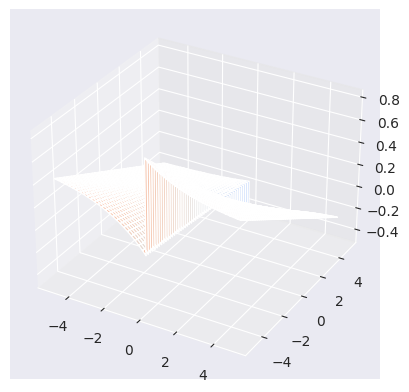

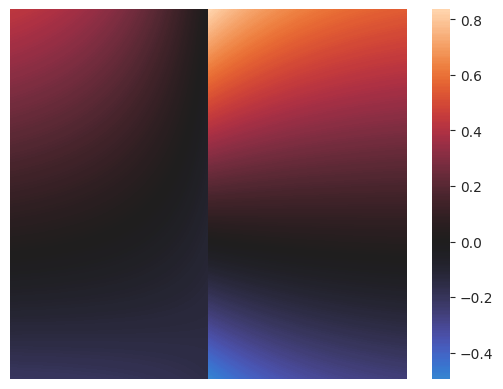

-0.41970086 0.024108905 0.35165706 0.16042039 0.39869103 -0.15590507 0.26653802 -0.06472884 -0.04196543 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


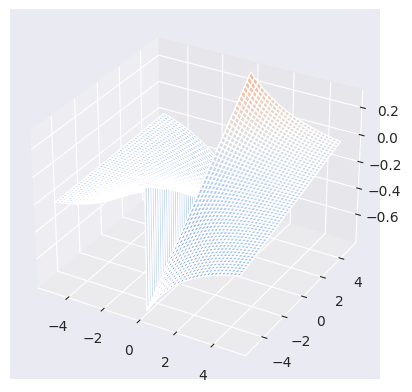

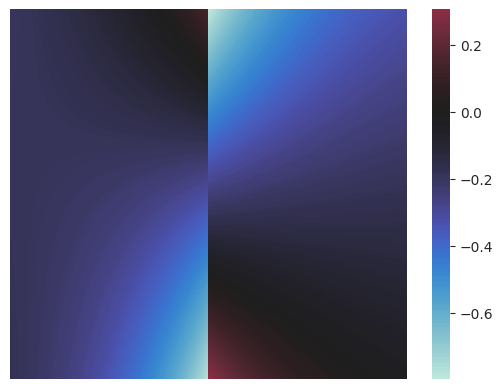

0.29620865 -0.18072501 0.1992444 -0.2704335 0.31734678 -0.25746775 0.28467742 0.15796907 0.27481553 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


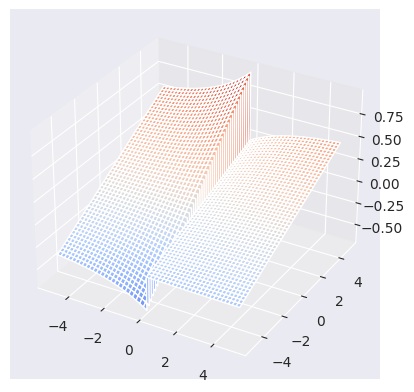

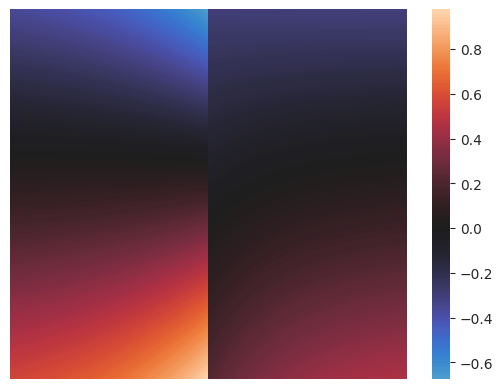

-0.22478814 0.3294182 0.52309465 0.24470948 0.15088496 0.05436574 0.04014201 0.11243023 -0.13829191 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


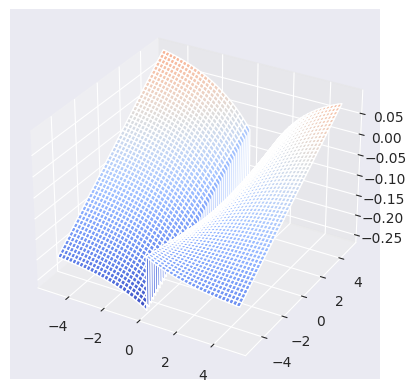

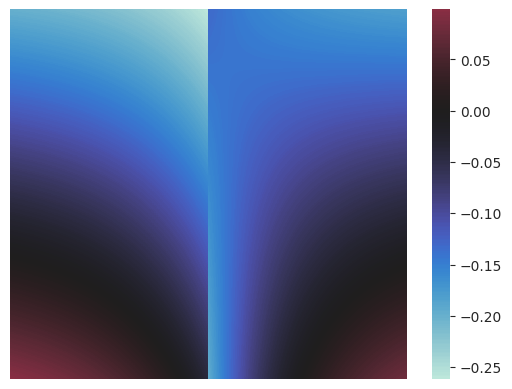

0.041579843 -0.38338637 0.593758 -0.6207915 -0.22138748 0.018923258 -0.43321508 0.33023536 -0.0030562768 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


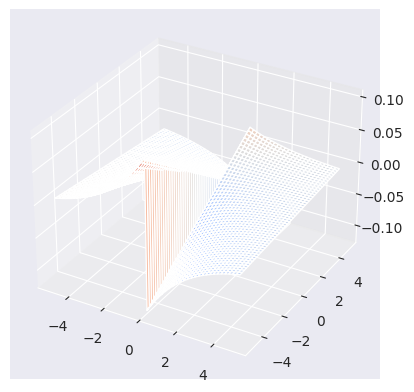

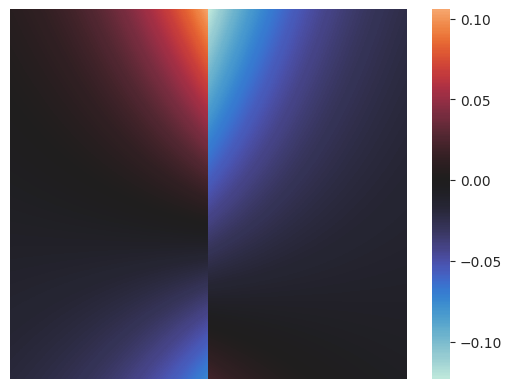

-0.24793117 -0.13469791 -0.16826147 0.28687114 0.20151713 -0.12868741 0.028415184 -0.17225367 0.2997753 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


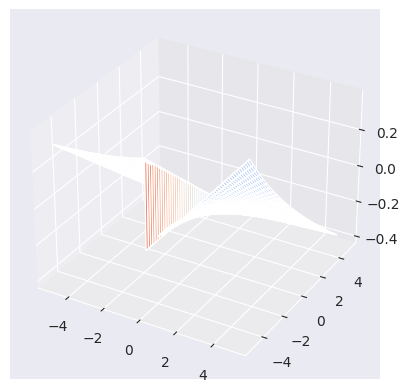

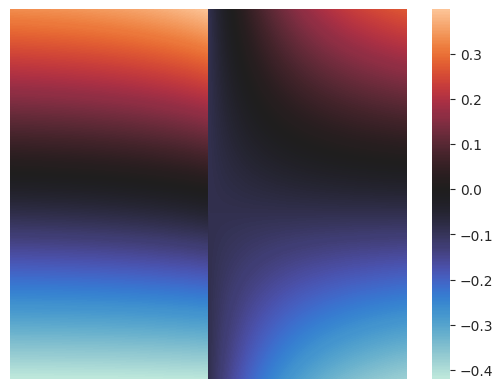

-0.24839826 -0.010692531 -0.0133516425 -0.30872306 -0.017068118 -0.20590954 -0.016828997 -0.0633595 -0.23408924 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


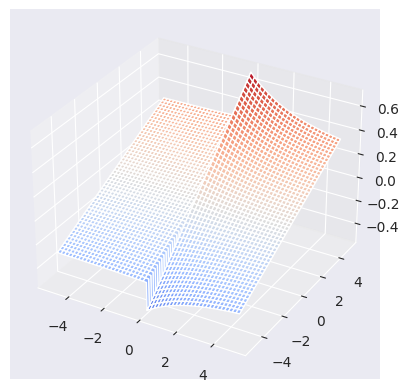

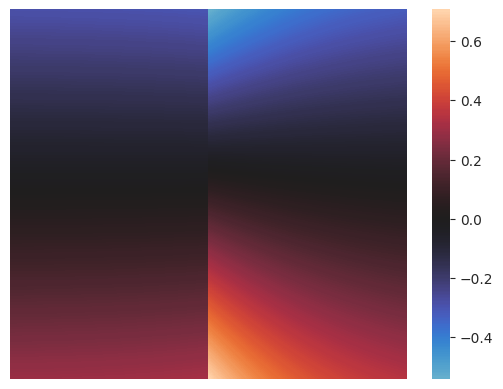

0.24994479 0.32287705 0.27265748 0.2422026 -0.09211166 -0.64531434 0.32565528 -0.12903948 0.37472165 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


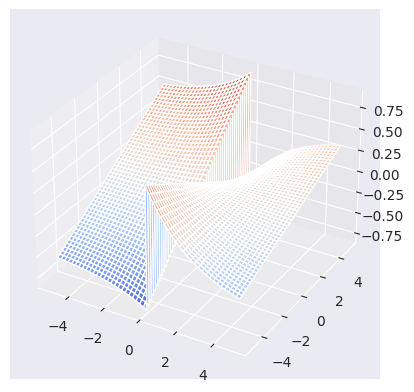

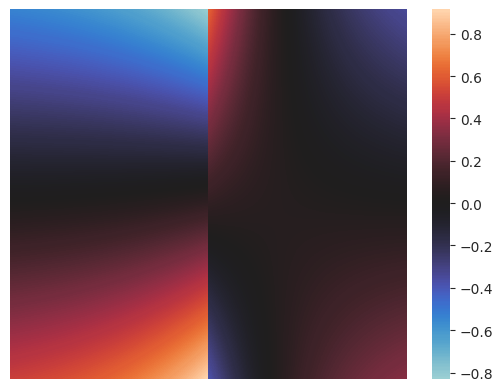

-0.09387117 -0.29809153 0.27172205 0.055420876 -0.07801549 -0.09504953 0.22328077 -0.15211596 0.20518951 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


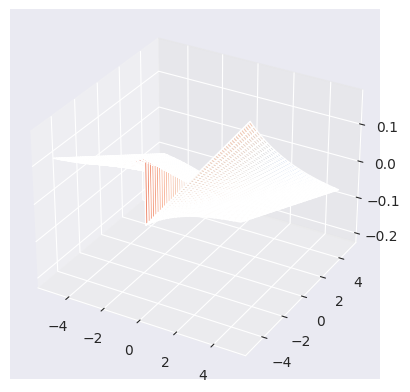

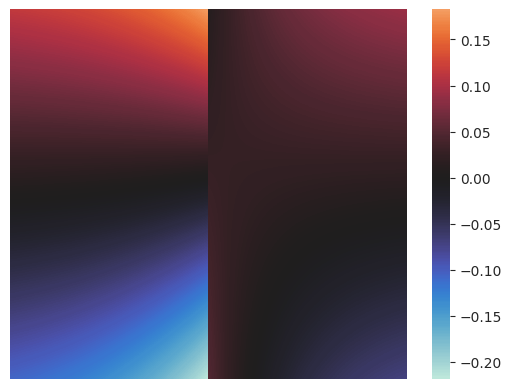

0.17398144 0.14348029 -0.18417448 0.07666173 -0.005537522 -0.026772154 -0.23713803 -0.06668954 0.039139967 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


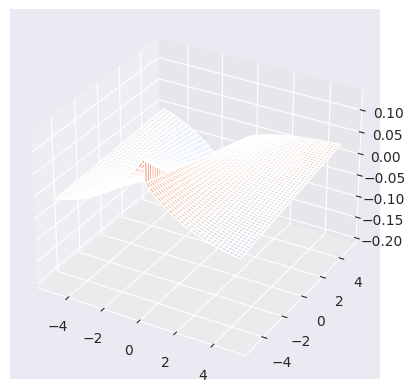

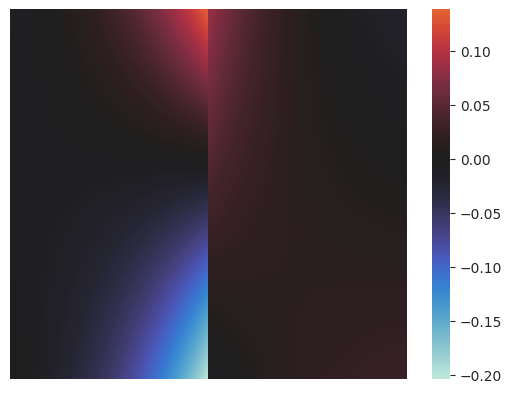

-0.4192766 0.06772638 -0.12140235 0.20067607 -0.5510149 -0.13134986 0.35381567 -0.021092337 0.28956437 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


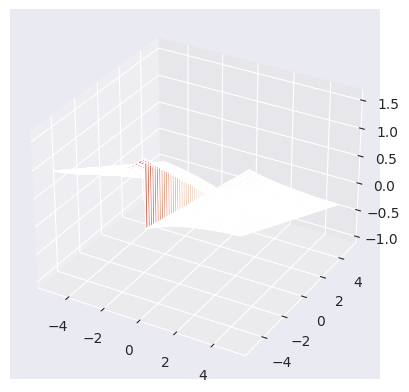

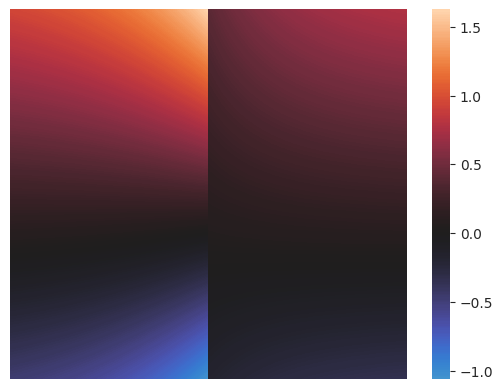

-0.09809265 0.26879746 0.4783909 0.3425789 -0.18180329 -0.48993838 -0.44851863 0.49158058 0.13400654 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


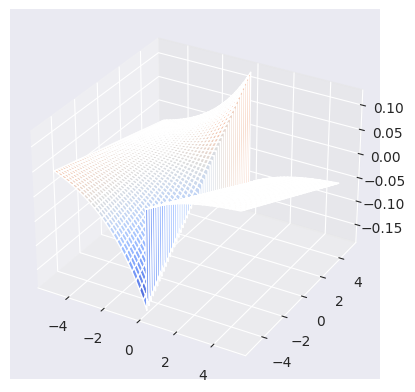

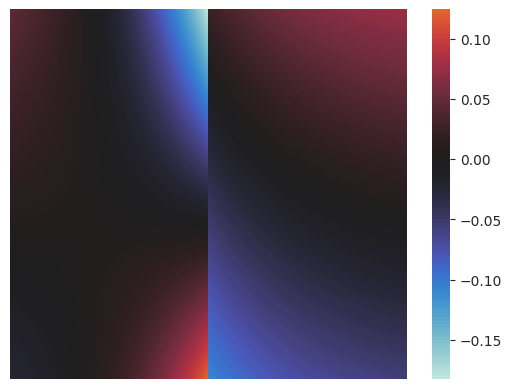

-0.09934741 -0.07754058 0.058066744 -0.5437015 0.121227354 -0.66398555 -0.05980785 0.022823498 0.06344748 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


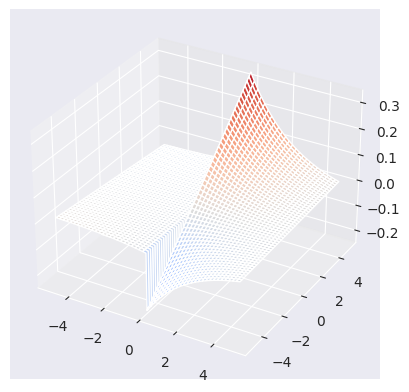

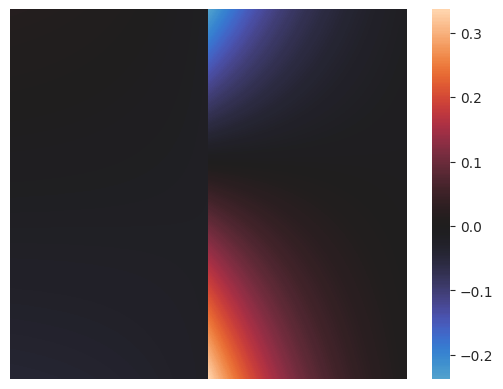

-0.029088503 -0.14934123 -0.039107297 0.07672335 -0.20899962 0.011833004 -0.6618188 -0.0055621127 0.00016079663 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


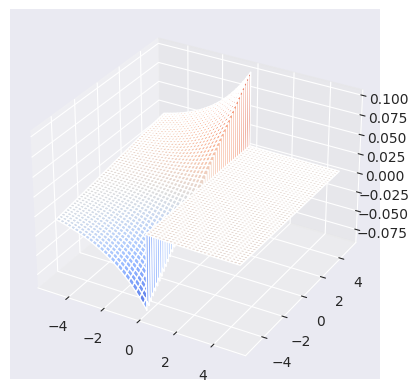

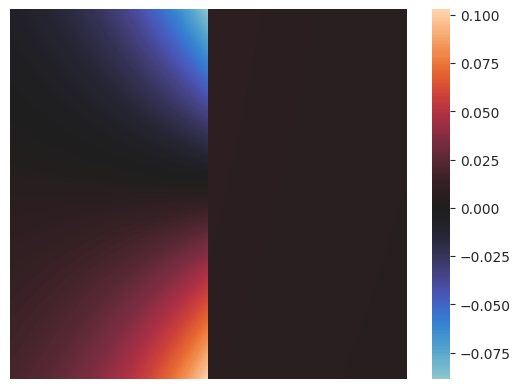

0.2901402 -0.14319403 -0.0975877 -0.08440905 0.19853152 -0.22558352 -0.05292413 0.07628088 0.13779487 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


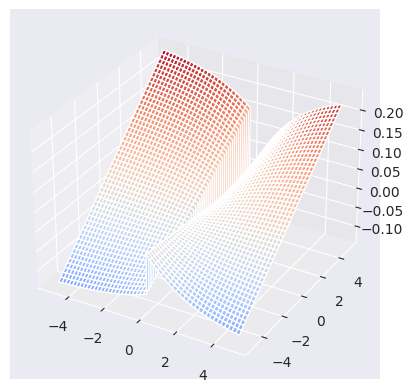

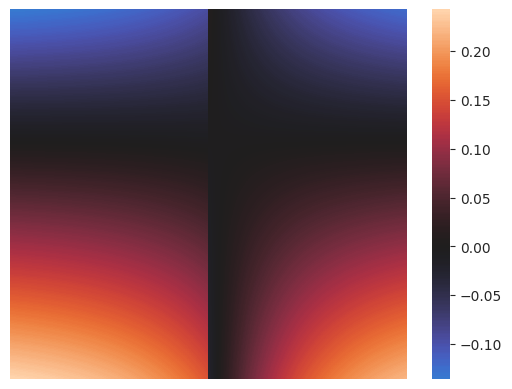

-0.071068645 0.050267458 0.15228066 -0.028917817 -0.4311731 0.15081987 0.0269269 0.06529486 0.35429475 0.3963631 0.4077521
(1000, 1000) (1000, 1000)


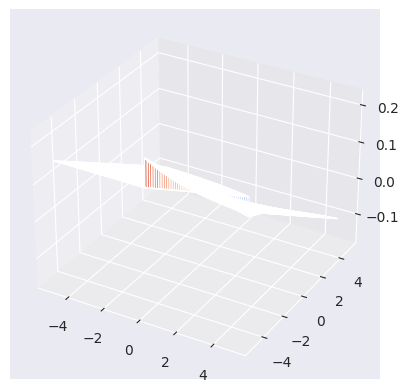


KeyboardInterrupt



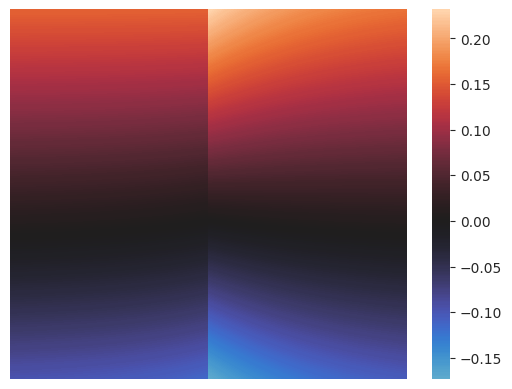

In [106]:
l = 1
LR, A, B, C, D, E, F, G, H = eval('params_layer_{}'.format(l))   # shape is [1, pre, post]
for i in range(LR.shape[1]):
    for j in range(LR.shape[2]):
        lr, a, b, c, d, e, f, g, h = \
            LR[l, i, j], \
            A[l, i, j], B[l, i, j], C[l, i, j], D[l, i, j], \
            E[l, i, j], F[l, i, j], G[l, i, j], H[l, i, j]
        # tau_pre = 1. / np.e
        tau_pre = _clip(eval('tau_{}'.format(l))[0][i, 0])
        tau_post = _clip(eval('tau_{}'.format(l))[0][i, 1])
        print(lr, a, b, c, d, e, f, g, h, tau_pre, tau_post)
        plot_dt_dw_3d(lr, a, b, c, d, e, f, g, h, tau_pre=tau_pre, tau_post=tau_post)
    break
        # plot_dt_dw(lr, a, b, c, d, e, f, g, h, tau_pre=tau_pre, tau_post=tau_post, w=0.)

In [72]:
def eval_with_injury(policy, env_name, obs_normalizer, params, obs_params, args, target=None):
    # def step_once(carry, input_data):
    #     (task_state, policy_state, params, obs_params,
    #      accumulated_reward) = carry
    #     task_state = task_state.replace(
    #         obs=obs_norm_fn(task_state.obs[None, :], obs_params))
    #     act, policy_state = act_fn(task_state, params[None, :], policy_state)
    #     task_state = task_state.replace(obs=task_state.obs[0])
    #     task_state = env.step(task_state, act[0])
    #     policy_state = update_fn(params[None, :], policy_state, None)
    #     accumulated_reward = accumulated_reward + task_state.reward
    #
    #     return ((task_state, policy_state, params, obs_params, accumulated_reward), (task_state))

    if target is None:
        target = {}
    env_fn = envs.create_fn(
        env_name=env_name,
        legacy_spring=True,
        # terminate_when_unhealthy=args.terminate_when_unhealthy,
        **target
    )
    env = env_fn()
    # state = env.reset(rng=jp.random_prngkey(seed=0))
    task_reset_fn = jax.jit(env.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(env.step)
    act_fn = jax.jit(policy.get_actions)
    update_fn = jax.jit(policy.update_fn) if hasattr(policy, 'update_fn') else lambda params, p_state, t_state: p_state
    obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

    total_reward = 0
    rollout = []
    rewards = []
    ws = []
    rng = jax.random.PRNGKey(seed=args.seed + 1)
    task_state = task_reset_fn(rng=rng)
    policy_state = policy_reset_fn(task_state)

    # accumulated_rewards = jnp.zeros((1, ))
    # task_states = jax.lax.scan(
    #     step_once,
    #     (task_state, policy_state, params, obs_params, accumulated_rewards),
    #     (), 1000
    # )
    # print(task_states)

    step = 0
    policy_states = [policy_state]
    task_states = [task_state]

    while not task_state.done:

        rollout.append(task_state)
        task_state = task_state.replace(
            obs=obs_norm_fn(task_state.obs[None, :], obs_params))
        act, policy_state = act_fn(task_state, params[None, :], policy_state)
        # For 50 steps, completely zero out the weights to see if the policy can
        # relearn weights that allow the ant to walk.
        # if step > 500 and step < 550:
        #     policy_state.fast_Ws[1] *= 0
        # task_state = step_fn(task_state, act[0])
        # jax.debug.breakpoint()
        task_state = task_state.replace(obs=task_state.obs[0])
        task_state = env.step(task_state, act[0])
        policy_state = update_fn(params[None, :], policy_state, None)
        total_reward = total_reward + task_state.reward
        rewards.append(task_state.reward)

        task_states.append(task_state)
        policy_states.append(policy_state)
        # Record the weights every 10 steps for visualisations.
        if hasattr(policy_state, 'fast_Ws') and step % 10 == 0:
            ws.append(policy_state.fast_Ws)
        step += 1

        if step % 10 == 0:
            print('[Eval with injury] {}, reward:{:.3e}'.format(step, total_reward))
    print('[Eval with injury] rollout reward = {}'.format(total_reward))

    ws = list(zip(*ws))
    for i, w in enumerate(ws):
        w = np.array(jnp.concatenate(w)[jnp.newaxis, :, jnp.newaxis, :, :])
        w = w.squeeze()
        media.show_video(w, height=w.shape[1] * 4, codec='gif', fps=5)

    fig, ax = plt.subplots()
    ax.plot(rewards)
    plt.show()
    return task_states, policy_states, rewards

(1, 0) (1, 66)
[Eval with injury] 10, reward:2.711e-02
[Eval with injury] 20, reward:3.723e-02
[Eval with injury] 30, reward:1.064e+00
[Eval with injury] 40, reward:1.047e+00
[Eval with injury] 50, reward:2.075e+00
[Eval with injury] 60, reward:3.127e+00
[Eval with injury] 70, reward:4.144e+00
[Eval with injury] 80, reward:5.191e+00
[Eval with injury] 90, reward:6.199e+00
[Eval with injury] 100, reward:7.219e+00
[Eval with injury] 110, reward:8.232e+00
[Eval with injury] 120, reward:9.235e+00
[Eval with injury] 130, reward:1.026e+01
[Eval with injury] 140, reward:1.029e+01
[Eval with injury] 150, reward:1.130e+01
[Eval with injury] 160, reward:1.131e+01
[Eval with injury] 170, reward:1.233e+01
[Eval with injury] 180, reward:1.436e+01
[Eval with injury] 190, reward:1.535e+01
[Eval with injury] 200, reward:1.636e+01
[Eval with injury] 210, reward:1.739e+01
[Eval with injury] 220, reward:1.839e+01
[Eval with injury] 230, reward:2.039e+01
[Eval with injury] 240, reward:2.142e+01
[Eval with

""

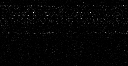

""

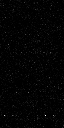

""


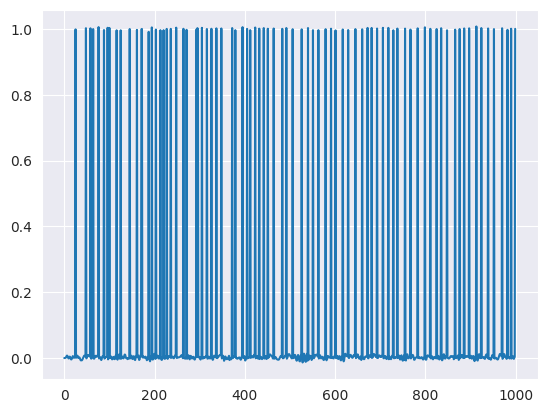

In [73]:
 task_states, policy_states, rewards = eval_with_injury(policy, args.env, obs_normalizer, best_params, obs_params, args)

In [77]:
len(policy_states[2].traces[1])

2

In [96]:
pre, post, ws = [], [], []
for state in policy_states:
    pre.append(state.traces[1][0][0])
    post.append(state.traces[1][1][0])
    ws.append(state.fast_Ws)

pre = np.stack(pre)
post = np.stack(post)

ws = list(zip(*ws))
for i in range(len(ws)):
    ws[i] = np.stack(ws[i])

print(ws[0].shape)

(1001, 1, 66, 128)


[]

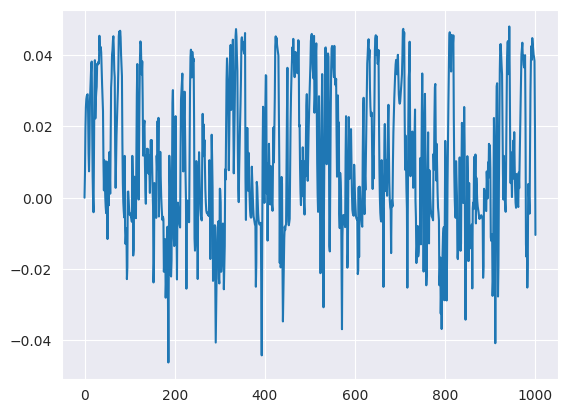

In [104]:
# plt.plot(pre[:, 4])
# plt.plot()
#
# plt.plot(post[:, 4])
# plt.plot()

plt.plot(ws[0][:, 0, 5, 32])
plt.plot()

/data/floyed/meta/train/PGPE-MetaNewStdpMLPPolicy-ur5e-single-20230316-121958  (seed 43 on 12)
/data/floyed/meta/train/PGPE-MetaNewStdpMLPPolicy-ant_dir-single-20230317-023453 (seed 42 on 12)
/data/floyed/meta/train/PGPE-MetaNewStdpMLPPolicy-halfcheetah_vel-single-20230316-141445 (seed 43 on 130)
/data/floyed/meta/train/PGPE-MetaNewStdpMLPPolicy-halfcheetah_vel--20230316-225025 (seed 41 on 144)
/data/floyed/meta/train/PGPE-MetaNewStdpMLPPolicy-ant_dir--20230316-225044 (seed 41 on 144)